Feature: Database
=================

The default behaviour of **PyAutoFit** is for model-fitting results to be output to hard-disc in folders, which are
straight forward to navigate and manually check. For small model-fitting tasks this is sufficient, however many users
have a need to perform many model fits to very large datasets, making manual inspection of results time consuming.

PyAutoFit's database feature outputs all model-fitting results as a
sqlite3 (https://docs.python.org/3/library/sqlite3.html) relational database, such that all results
can be efficiently loaded into a Jupyter notebook or Python script for inspection, analysis and interpretation. This
database supports advanced querying, so that specific model-fits (e.g., which fit a certain model or dataset) can be
loaded.

This example extends our example of fitting a 1D `Gaussian` profile and fits 3 independent datasets each containing a
1D Gaussian. The results will be written to a `.sqlite` database, which we will load to demonstrate the database.

A full description of PyAutoFit's database tools is provided in the database chapter of the `HowToFit` lectures.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
import autofit.plot as aplt

from os import path
import numpy as np

import model as m
import analysis as a

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


__Dataset Names__

For each dataset we load it from hard-disc, set up its `Analysis` class and fit it with a non-linear search. 

The 3 datasets are in the `autofit_workspace/dataset/example_1d` folder.

We want each results to be stored in the database with an entry specific to the dataset, by generating the unique
identifier using the name of the dataset. We'll use the `dataset_name` string to do this, so lets create a list of 
the 3 dataset names.

In [2]:
dataset_names = ["gaussian_x1_0", "gaussian_x1_1", "gaussian_x1_2"]

__Info__

Information about our model-fit that isn't part of the model-fit can be made accessible to the database, by passing 
an `info` dictionary. 

For example, below we write info on the dataset`s (hypothetical) data of observation and exposure time, which the
database will be able to access.

In [3]:
info = {"date_of_observation": "01-02-18", "exposure_time": 1000.0}

__Model__

Next, we create our model, which again corresponds to a single `Gaussian` with manual priors.

In [4]:
model = af.Collection(gaussian=m.Gaussian)

model.gaussian.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.gaussian.intensity = af.LogUniformPrior(lower_limit=1e-2, upper_limit=1e2)
model.gaussian.sigma = af.GaussianPrior(
    mean=10.0, sigma=5.0, lower_limit=0.0, upper_limit=np.inf
)

___Session__

To output results directly to the database, we start a session, which includes the name of the database `.sqlite` file
where results are stored.

In [5]:
session = af.db.open_database("database.sqlite")

This for loop runs over every dataset, checkout the comments below for how we set up the database entry of each fit.

Note how the `session` is passed to the `Emcee` search.

In [6]:
for dataset_name in dataset_names:

    """
    The code below loads the dataset and sets up the Analysis class.
    """
    dataset_path = path.join("dataset", "example_1d", dataset_name)

    data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
    noise_map = af.util.numpy_array_from_json(
        file_path=path.join(dataset_path, "noise_map.json")
    )

    analysis = a.Analysis(data=data, noise_map=noise_map)

    """
    In all examples so far, results were written to the `autofit_workspace/output` folder with a path and folder 
    named after a unique identifier, which was derived from the non-linear search and model. This unique identifier
    plays a vital role in the database: it is used to ensure every entry in the database is unique. 
    
    In this example, results are written directly to the `database.sqlite` file after the model-fit is complete and 
    only stored in the output folder during the model-fit. This can be important for performing large model-fitting 
    tasks on high performance computing facilities where there may be limits on the number of files allowed, or there
    are too many results to make navigating the output folder manually feasible.
    
    The `unique_tag` below uses the `dataset_name` to alter the unique identifier, which as we have seen is also 
    generated depending on the search settings and model. In this example, all three model fits use an identical 
    search and model, so this `unique_tag` is key for ensuring 3 separate sets of results for each model-fit are 
    stored in the output folder and written to the .sqlite database. 
    """
    emcee = af.Emcee(
        path_prefix=path.join("features", "database"),
        unique_tag=dataset_name,  # This makes the unique identifier use the dataset name
        session=session,  # This instructs the search to write to the .sqlite database.
        nwalkers=30,
        nsteps=1000,
        initializer=af.InitializerBall(lower_limit=0.49, upper_limit=0.51),
        auto_correlations_settings=af.AutoCorrelationsSettings(
            check_for_convergence=True,
            check_size=100,
            required_length=50,
            change_threshold=0.01,
        ),
        number_of_cores=1,
    )

    print(
        f"Emcee has begun running. This Jupyter notebook cell with progress once Emcee has completed, this could take a "
        f"few minutes!"
    )

    result = emcee.fit(model=model, analysis=analysis, info=info)

print("Emcee has finished run - you may now continue the notebook.")

2021-05-10 10:13:23,902 - root - INFO -  already completed, skipping non-linear search.


Emcee has begun running. This Jupyter notebook cell with progress once Emcee has completed, this could take a few minutes!


2021-05-10 10:13:25,483 - root - INFO -  already completed, skipping non-linear search.


Emcee has begun running. This Jupyter notebook cell with progress once Emcee has completed, this could take a few minutes!


2021-05-10 10:13:27,263 - root - INFO -  already completed, skipping non-linear search.


Emcee has begun running. This Jupyter notebook cell with progress once Emcee has completed, this could take a few minutes!
Emcee has finished run - you may now continue the notebook.


First, note how the results are not contained in the `output` folder after each search completes. Instead, they are
contained in the `database.sqlite` file, which we can load using the `Aggregator`.

In [7]:
agg = af.Aggregator.from_database("database.sqlite")

Before using the aggregator to inspect results, let me quickly cover Python generators. A generator is an object that 
iterates over a function when it is called. The aggregator creates all of the objects that it loads from the database 
as generators (as opposed to a list, or dictionary, or other Python type).

Why? Because lists and dictionaries store every entry in memory simultaneously. If you fit many datasets, this will use 
a lot of memory and crash your laptop! On the other hand, a generator only stores the object in memory when it is used; 
Python is then free to overwrite it afterwards. Thus, your laptop won't crash!

There are two things to bare in mind with generators:

 1) A generator has no length and to determine how many entries it contains you first must turn it into a list.

 2) Once we use a generator, we cannot use it again and need to remake it. For this reason, we typically avoid 
 storing the generator as a variable and instead use the aggregator to create them on use.

We can now create a `samples` generator of every fit. As we saw in the `result.py` example scripts, an instance of 
the `Samples` class acts as an interface to the results of the non-linear search.

In [8]:
samples_gen = agg.values("samples")

When we convert this generator to a list and it, the outputs are 3 different MCMCSamples instances. These correspond to 
the 3 model-fits performed above.

In [9]:
print("Emcee Samples:\n")
print(samples_gen)
print("Total Samples Objects = ", len(list(samples_gen)), "\n")

Emcee Samples:

[<autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7fddd2932dc0>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7fddcfd3b3d0>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7fddcebe7be0>]
Total Samples Objects =  3 



The `Samples` class is described in the `result.py` example script. Using the `Aggregator` we can access all of the 
attributes described in that example, for example the value of every parameter.

Refer to `result.py` for all the properties that are accessible via the `Aggregator`.

In [10]:
for samples in agg.values("samples"):
    print("All parameters of the very first sample")
    print(samples.parameter_lists[0])
    print("The tenth sample`s third parameter")
    print(samples.parameter_lists[9][2], "\n")

All parameters of the very first sample
[49.48650891626451, 1.131418117581497, 9.884375537720414]
The tenth sample`s third parameter
9.987740772476311 

All parameters of the very first sample
[49.87955795424473, 1.0967028797692882, 9.90644110673836]
The tenth sample`s third parameter
10.104247100690458 

All parameters of the very first sample
[49.38072470880848, 0.9965358848464873, 10.040150468331118]
The tenth sample`s third parameter
10.08130355390232 



__Querying__

We can use the `Aggregator`'s to query the database and return only specific fits that we are interested in. We first 
do this, using the `info` object, whereby we can query any of its entries, for example the `dataset_name` string we 
input into the model-fit above. 

By querying using the string `gaussian_x1_1` the model-fit to only the second `Gaussian` dataset is returned:

In [11]:
# Feature Missing

# agg_query = agg.query(agg.directory.contains("gaussian_x1_1"))
# samples_gen = agg_query.values("samples")

As expected, this list now has only 1 MCMCSamples corresponding to the second dataset.

In [12]:
print(samples_gen)
print("Total Samples Objects via dataset_name Query = ", len(list(samples_gen)), "\n")

[<autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7fddd2932dc0>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7fddcfd3b3d0>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7fddcebe7be0>]
Total Samples Objects via dataset_name Query =  3 



We can also query based on the model fitted. 

For example, we can load all results which fitted a `Gaussian` model-component, which in this simple example is all
3 model-fits.
 
The ability to query via the model is extremely powerful. It enables a user to perform many model-fits with many 
different model parameterizations to large datasets and efficiently load and inspect the results. 

[Note: the code `agg.gaussian` corresponds to the fact that in the `Collection` above, we named the model
component `gaussian`. If this `Collection` had used a different name the code below would change 
correspondingly. Models with multiple model components (e.g., `gaussian` and `exponential`) are therefore also easily 
accessed via the database.]

In [13]:
gaussian = agg.gaussian
agg_query = agg.query(gaussian == m.Gaussian)
samples_gen = agg_query.values("samples")
print(
    "Total Samples Objects via `Gaussian` model query = ", len(list(samples_gen)), "\n"
)

Total Samples Objects via `Gaussian` model query =  3 



Queries using the results of model-fitting are also supported. Below, we query the database to find all fits where the 
inferred value of `sigma` for the `Gaussian` is less than 3.0 (which returns only the first of the three model-fits).

In [14]:
gaussian = agg.gaussian
agg_query = agg.query(gaussian.sigma < 3.0)
samples_gen = agg_query.values("samples")
print(
    "Total Samples Objects In Query `gaussian.sigma < 3.0` = ",
    len(list(samples_gen)),
    "\n",
)

Total Samples Objects In Query `gaussian.sigma < 3.0` =  0 



Advanced queries can be constructed using logic, for example we below we combine the two queries above to find all
results which fitted a `Gaussian` AND (using the & symbol) inferred a value of sigma less than 3.0. 

The OR logical clause is also supported via the symbol |.

In [15]:
gaussian = agg.gaussian
agg_query = agg.query((gaussian == m.Gaussian) & (gaussian.sigma < 3.0))
samples_gen = agg_query.values("samples")
print(
    "Total Samples Objects In Query `Gaussian & sigma < 3.0` = ",
    len(list(samples_gen)),
    "\n",
)

Total Samples Objects In Query `Gaussian & sigma < 3.0` =  0 



The Probability Density Functions (PDF's) of the every model-fit can be plotted using the Emcee's visualization 
tool `corner.py`, which is wrapped via the `EmceePlotter` object.

2021-05-10 10:13:31,589 - root - WARNING - Too few points to create valid contours
2021-05-10 10:13:31,620 - root - WARNING - Too few points to create valid contours
2021-05-10 10:13:31,641 - root - WARNING - Too few points to create valid contours


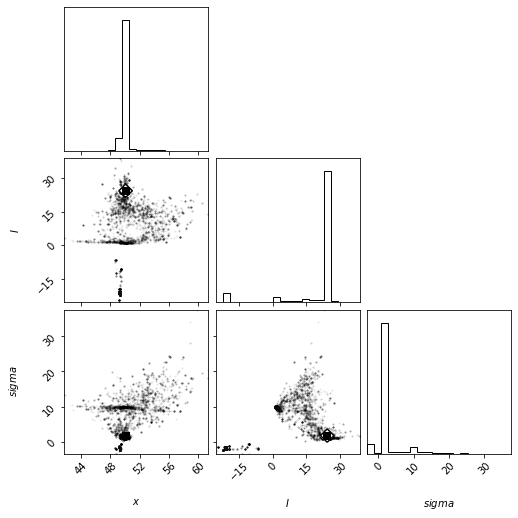

2021-05-10 10:13:32,199 - root - WARNING - Too few points to create valid contours
2021-05-10 10:13:32,228 - root - WARNING - Too few points to create valid contours
2021-05-10 10:13:32,249 - root - WARNING - Too few points to create valid contours


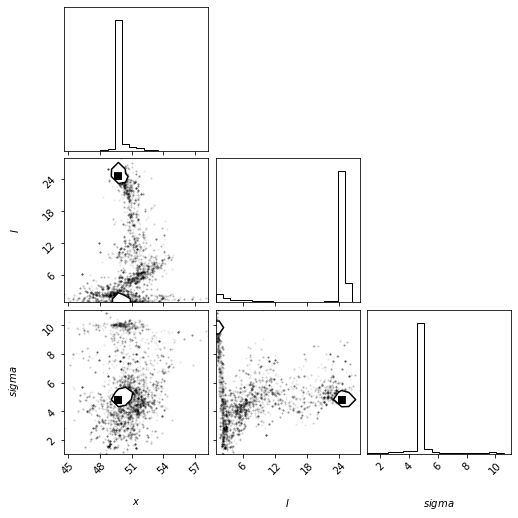

2021-05-10 10:13:32,733 - root - WARNING - Too few points to create valid contours
2021-05-10 10:13:32,762 - root - WARNING - Too few points to create valid contours
2021-05-10 10:13:32,900 - root - WARNING - Too few points to create valid contours


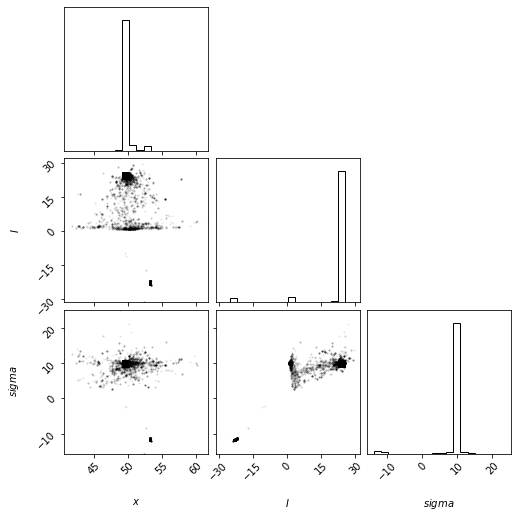

In [16]:
for samples in agg.values("samples"):

    emcee_plotter = aplt.EmceePlotter(samples=samples)
    emcee_plotter.corner()

The API for querying is fairly self explanatory. Through the combination of info based queries, model based
queries and result based queries a user has all the tools they need to fit extremely large datasets with many different
models and load only the results they are interested in for inspection and analysis.

The Database chapter of the **HowToFit** Jupyter notebooks give a full description of the database feature, including 
examples of advanced queries and how to load and plot the results of a model-fit in more detail.